In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


/Users/jameelamer/MasterProject/Summarization/summrization_webapp/flaskProject2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Load dataset
df = pd.read_csv("bbc_news_summary_with_articles.csv")  

In [3]:
df.head()

,Title,Article,Summary,Category
0,289,Musicians to tackle US red tape\n\nMusicians' ...,Nigel McCune from the Musicians' Union said Br...,entertainment
1,262,"U2's desire to be number one\n\nU2, who have w...",But they still want more.They have to want to ...,entertainment
2,276,Rocker Doherty in on-stage fight\n\nRock singe...,"Babyshambles, which he formed after his acrimo...",entertainment
3,60,Snicket tops US box office chart\n\nThe film a...,A Series of Unfortunate Events also stars Scot...,entertainment
4,74,Ocean's Twelve raids box office\n\nOcean's Twe...,"Ocean's Twelve, the crime caper sequel starrin...",entertainment


In [4]:
# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['Category'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['Article'], df['label'], test_size=0.2, random_state=42)

In [5]:
# Load SBERT model (you can choose others like 'all-MiniLM-L6-v2')
model = SentenceTransformer('all-MiniLM-L6-v2')


In [6]:
# Reset index to avoid issues during encoding
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [7]:
# Sanity check: Ensure all values are strings
X_train = X_train.astype(str)
X_test = X_test.astype(str)

# Optional: Remove NaNs
X_train = X_train.fillna('')
X_test = X_test.fillna('')

In [8]:
# Generate embeddings with SBERT
X_train_embeddings = model.encode(X_train.tolist(), show_progress_bar=True)
X_test_embeddings = model.encode(X_test.tolist(), show_progress_bar=True)

Batches: 100%|██████████| 14/14 [00:01<00:00,  8.92it/s]


In [9]:
# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_embeddings, y_train)

LogisticRegression(max_iter=1000)

In [10]:
# Evaluate
y_pred = clf.predict(X_test_embeddings)
print(classification_report(y_test, y_pred, target_names=le.classes_))

               precision    recall  f1-score   support

     business       0.93      0.95      0.94       103
entertainment       1.00      0.99      0.99        84
     politics       0.96      0.94      0.95        80
        sport       0.98      1.00      0.99        98
         tech       0.97      0.96      0.97        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



In [11]:
def classify_query(query):
    embedding = model.encode([query])
    pred_label = clf.predict(embedding)[0]
    return le.inverse_transform([pred_label])[0]

# Example usage
print(classify_query("Government plans new tax policies for small businesses"))
print(classify_query("Real Madrid scores two late goals to secure the win"))


business
sport


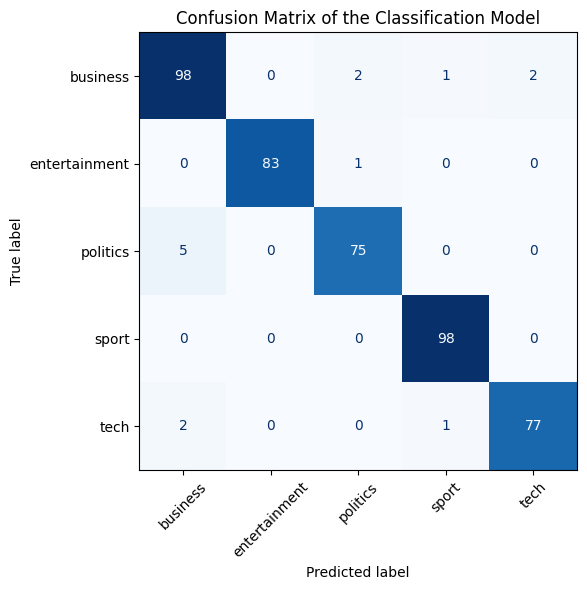

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predictions and compute confusion matrix
y_pred = clf.predict(X_test_embeddings)
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix of the Classification Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [20]:
import joblib

# Save classifier and label encoder
joblib.dump(clf, 'sbert_classifier.pkl')
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']

In [21]:
from sentence_transformers import SentenceTransformer
import joblib

# Load components
model = SentenceTransformer('all-MiniLM-L6-v2')  # reload SBERT model by name
clf = joblib.load('sbert_classifier.pkl')
le = joblib.load('label_encoder.pkl')

# Prediction function
def classify_query(text):
    embedding = model.encode([text])
    pred = clf.predict(embedding)[0]
    return le.inverse_transform([pred])[0]

# Example
print(classify_query("New technology trends in AI and machine learning"))

tech


In [24]:
# Example
print(classify_query("what is the sport with AI"))

tech
